In [1]:
import plyfile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_cow(every_ith=200):
    from plyfile import PlyData
    plydata = PlyData.read('cow.2D.ply')

    X = np.array([plydata["vertex"][c] for c in ["y", "x"]]).T
    X[:,1] = -X[:,1]
    N = np.array([plydata["vertex"][c] for c in ["ny", "nx"]]).T
    N[:,1] = -N[:,1]
    return X[::every_ith],N[::every_ith]

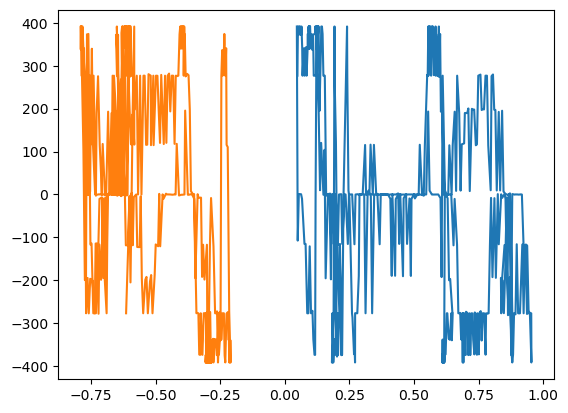

In [3]:
plt.plot(*load_cow())
plt.show()